# Plot CC_18 Benchmarks

In [29]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [30]:
import sys
from pathlib import Path
import numpy as np
import collections
import pickle
from pathlib import Path

import pandas as pd
import openml

from sklearn.metrics import cohen_kappa_score

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

sys.path.append("../")

from oblique_forests.sporf import ObliqueForestClassifier

# from rerf.rerfClassifier import rerfClassifier

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def continuous_pairplot(df, vars, hue, cmap, diag_kind="auto", scale="log"):
    import matplotlib as mpl
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    vmin = min(np.nanmin([df[hue]]), -1e-6)
    vmax = max(np.nanmax([df[hue]]), 1e-6)

    g = sns.pairplot(
        df,
        vars=vars,
        diag_kind=diag_kind,
        plot_kws=dict(
            # The effort I put into figuring this out.....
            c=df[hue],
            cmap=cmap,
            norm=mpl.colors.TwoSlopeNorm(vcenter=0, vmin=vmin, vmax=vmax),
        ),
    )
    if scale:
        for r in range(len(g.axes)):
            for c in range(len(g.axes)):
                g.axes[r, c].set_xscale(scale)
                if r != c:
                    g.axes[c, r].set_yscale(scale)

    sm = mpl.cm.ScalarMappable(
        mpl.colors.TwoSlopeNorm(vcenter=0, vmin=vmin, vmax=vmax), cmap=cmap
    )
    plt.colorbar(sm, ax=g.axes, label=hue, aspect=40)
    return g

# Get the data

In [4]:
intermediate_fpath = "./cc18_benchmark/rerf_cc_18_sporf_vs_rf_benchmarks.csv"

In [16]:
# if both start/stop are None, then run on all tasks
start_id = None
stop_id = None

name = "hackerman_master"
name = "optimizebranch"
overwrite = True

# cross validation
cv = 10

vary_samples = False

# hyperparameters of forest
max_features = None
max_features = "sqrt"

# directory to save the output
data_dir = Path("/home/adam2392/Downloads")
data_dir = Path("/Users/adam2392/Dropbox/sporf_benchmarks")

## Get Data Separately for Rerf and RF

In [ ]:
# folder to save results
folder = data_dir / f"rerf/results_cv{cv}_features={max_features}"  # _{name}"

result_files = [
    f for f in folder.glob("*.pkl") if any([f.name in x.name for x in rf_result_files])
]
print(len(result_files))

In [17]:
# folder to save results
folder = data_dir / f"results_cv{cv}_features={max_features}_{name}"

rf_result_files = [
    f for f in folder.glob("*.pkl") if any([f.name in x.name for x in result_files])
]

print(len(rf_result_files))

0


## Get Data That Are Grouped in 1 PCKL file

In [18]:
# folder to save results
folder = data_dir / f"results_cv{cv}_features={max_features}"  # _{name}"

result_files = [f for f in folder.glob("*.pkl")]
print(len(result_files))

print(folder)

72
/Users/adam2392/Dropbox/sporf_benchmarks/results_cv10_features=sqrt


In [19]:
def _get_task_id(desired_task_name):
    benchmark_suite = openml.study.get_suite(
        "OpenML-CC18"
    )  # obtain the benchmark suite
    for task_id in benchmark_suite.tasks:
        task = openml.tasks.get_task(task_id)  # download the OpenML task
        task_name = task.get_dataset().name
        if task_name == desired_task_name:
            n_features = task.get_dataset().get_data()[0].shape[1]
            return n_features
    raise Exception(f"Didnt find {desired_task_name}")

In [24]:
tasks = []
n_samples = []
n_classes = []
n_features = []
sporf_cohens = []
rf_cohens = []
rerf_sporf_cohens = []
task_ids = []

### Get Results for Rerf Files

In [20]:
for fpath in result_files:
    with open(fpath, "rb") as fin:
        result_dict = pickle.load(fin)

    # number of stratified cross-validations
    cv = result_dict["cv"]
    fold_test_inds = result_dict["test_indices"]
    y = result_dict["y"]
    task_name = result_dict["task"]
    n_feature = result_dict["n_features"]
    #     n_feature = _get_task_id(desired_task_name=task_name)

    # extract metadata of benchmark experiment
    tasks.append(task_name)
    n_samples.append(result_dict["n_samples"])
    n_classes.append(result_dict["n_classes"])
    task_ids.append(result_dict["task_id"])
    n_features.append(n_feature)

    # compute cohen kappa for both classifiers
    for clf in [
        "rerfSPORF",
        #                 "RF", 
#         "SPORF"
    ]:
        clf_cohens = []
        fold_probas = result_dict[clf]

        # compute statistic on each fold
        for ifold in range(cv):
            y_proba = fold_probas[ifold][0]
            y_test = y[fold_test_inds[ifold]]
            kappa_score = cohen_kappa_score(y_test, y_proba.argmax(1))
            clf_cohens.append(kappa_score)

        rerf_sporf_cohens.append(clf_cohens)

KeyError: 'rerfSPORF'

### Get Results for RF + CySpoorf Files

In [25]:
for fpath in result_files:
    with open(fpath, "rb") as fin:
        result_dict = pickle.load(fin)

    # number of stratified cross-validations
    cv = result_dict["cv"]
    fold_test_inds = result_dict["test_indices"]
    y = result_dict["y"]
    task_name = result_dict["task"]
    n_feature = result_dict["n_features"]
    #     n_feature = _get_task_id(desired_task_name=task_name)

    # extract metadata of benchmark experiment
    tasks.append(task_name)
    n_samples.append(result_dict["n_samples"])
    n_classes.append(result_dict["n_classes"])
    task_ids.append(result_dict["task_id"])
    n_features.append(n_feature)

    # compute cohen kappa for both classifiers
    for clf in ["RF", "SPORF"]:
        clf_cohens = []
        fold_probas = result_dict[clf]

        # compute statistic on each fold
        for ifold in range(cv):
            y_proba = fold_probas[ifold][0]
            y_test = y[fold_test_inds[ifold]]
            kappa_score = cohen_kappa_score(y_test, y_proba.argmax(1))
            clf_cohens.append(kappa_score)

        if clf == "RF":
            rf_cohens.append(clf_cohens)
        else:
            sporf_cohens.append(clf_cohens)

In [26]:
print(max(task_ids))

167141


In [27]:
print(np.array(rf_cohens).shape)

(72, 10)


In [28]:
result_df = pd.DataFrame((tasks, n_samples, n_classes, task_ids, n_features)).T
result_df.columns = ["task", "n_samples", "n_classes", "task_id", "n_features"]

print(result_df.shape)
display(result_df.head())

(72, 5)


,task,n_samples,n_classes,task_id,n_features
0,Devnagari-Script,92000,46,167121,1024
1,segment,2310,7,146822,16
2,jungle_chess_2pcs_raw_endgame_complete,44819,3,167119,6
3,tic-tac-toe,958,2,49,9
4,pc1,1109,2,3918,21


## Saving Intermediate Results

In [141]:
result_df.to_csv(intermediate_fpath)

## Process CySPORF vs RF

In [31]:
rf_df = pd.DataFrame(rf_cohens)
rf_df["clf"] = "rf"
rf_df = pd.concat((rf_df, result_df), axis=1)

sporf_df = pd.DataFrame(sporf_cohens)
sporf_df["clf"] = "sporf"
sporf_df = pd.concat((sporf_df, result_df), axis=1)

diff_arr = np.array(sporf_cohens) - np.array(rf_cohens)
diff_df = pd.DataFrame(diff_arr)
diff_df = pd.concat((diff_df, result_df), axis=1)

# now form the final dataframe
data_df = pd.concat((rf_df, sporf_df), axis=0)

# print(rf_df.shape)
# display(rf_df.head())
print(data_df.shape)
print(diff_df.shape)
display(diff_df.head())
display(data_df.head())

(144, 16)
(72, 15)


,0,1,2,3,4,5,6,7,8,9,task,n_samples,n_classes,task_id,n_features
0,-0.009778,-0.009222,-0.005556,-0.009556,-0.009333,-0.006333,-0.009000,-0.008667,-0.010000,-8.000000e-03,Devnagari-Script,92000,46,167121,1024
1,-0.015152,0.010101,0.005051,0.005051,0.005051,0.000000,0.025253,0.000000,0.000000,1.110223e-16,segment,2310,7,146822,16
2,0.052629,0.046453,0.044947,0.058755,0.048107,0.041439,0.056726,0.048809,0.045495,5.645082e-02,jungle_chess_2pcs_raw_endgame_complete,44819,3,167119,6
3,-0.119760,-0.023944,-0.023596,-0.178037,-0.071841,-0.172763,-0.046154,-0.045541,-0.070818,-9.419931e-02,tic-tac-toe,958,2,49,9
4,-0.323811,0.000000,0.000000,-0.382189,0.000000,-0.137167,0.082505,0.000000,-0.161344,-4.372557e-02,pc1,1109,2,3918,21


,0,1,2,3,4,5,6,7,8,9,clf,task,n_samples,n_classes,task_id,n_features
0,0.924778,0.921778,0.915889,0.921556,0.926667,0.922444,0.921778,0.919778,0.923667,0.922444,rf,Devnagari-Script,92000,46,167121,1024
1,0.914141,0.924242,0.944444,0.924242,0.944444,0.939394,0.924242,0.929293,0.944444,0.924242,rf,segment,2310,7,146822,16
2,0.604739,0.616718,0.621763,0.618678,0.630027,0.639495,0.619113,0.628938,0.625872,0.617223,rf,jungle_chess_2pcs_raw_endgame_complete,44819,3,167119,6
3,1.000000,0.953148,0.976744,0.929204,0.976744,0.976744,1.000000,1.000000,0.976618,1.000000,rf,tic-tac-toe,958,2,49,9
4,0.523605,0.085165,0.474763,0.382189,0.526854,0.474763,0.299685,0.176252,0.337596,0.472000,rf,pc1,1109,2,3918,21


In [92]:
rf_df = pd.DataFrame(rf_cohens)
rf_df["clf"] = "rf"
rf_df = pd.concat((rf_df, result_df), axis=1)

sporf_df = pd.DataFrame(sporf_cohens)
sporf_df["clf"] = "sporf"
sporf_df = pd.concat((sporf_df, result_df), axis=1)

rerf_sporf_df = pd.DataFrame(rerf_sporf_cohens)
rerf_sporf_df["clf"] = "rerfSPORF"
rerf_sporf_df = pd.concat((rerf_sporf_df, result_df), axis=1)

diff_arr = np.array(rerf_sporf_cohens) - np.array(sporf_cohens)
diff_df = pd.DataFrame(diff_arr)
diff_df = pd.concat((diff_df, result_df), axis=1)

# now form the final dataframe
data_df = pd.concat((rf_df, sporf_df, rerf_sporf_df), axis=0)

# print(rf_df.shape)
# display(rf_df.head())
print(data_df.shape)
print(diff_df.shape)
display(diff_df.head())
display(data_df.head())

(396, 16)
(132, 15)


,0,1,2,3,4,5,6,7,8,9,task,n_samples,n_classes,task_id,n_features
0,0.010101,0.005051,0.000000,0.000000,0.005051,0.005051,-0.020202,0.000000,0.010101,0.015152,segment,2310,7,146822,16
1,-0.013970,-0.004618,-0.001584,-0.007687,-0.011820,0.002283,-0.017322,-0.011752,-0.006384,-0.009757,jungle_chess_2pcs_raw_endgame_complete,44819,3,167119,6
2,0.167665,0.000000,0.046512,0.153737,0.094738,0.248834,0.022923,0.068768,0.170595,0.168482,tic-tac-toe,958,2,49,9
3,0.448383,0.016380,0.255214,0.382189,-0.052091,0.298511,-0.115131,0.353873,0.161344,0.043726,pc1,1109,2,3918,21
4,-0.040327,-0.041712,0.034621,-0.012003,-0.012515,-0.058530,0.000714,0.060655,0.015254,0.077218,analcatdata_dmft,797,6,3560,4


,0,1,2,3,4,5,6,7,8,9,clf,task,n_samples,n_classes,task_id,n_features
0,0.919192,0.934343,0.949495,0.924242,0.949495,0.934343,0.929293,0.929293,0.949495,0.924242,rf,segment,2310,7,146822,16
1,0.605763,0.618974,0.625251,0.622599,0.626951,0.640233,0.617858,0.627974,0.625333,0.615132,rf,jungle_chess_2pcs_raw_endgame_complete,44819,3,167119,6
2,1.000000,0.953148,0.976744,0.929204,0.976744,1.000000,1.000000,1.000000,0.976618,1.000000,rf,tic-tac-toe,958,2,49,9
3,0.523605,0.101545,0.474763,0.209563,0.526854,0.474763,0.299685,0.176252,0.337596,0.472000,rf,pc1,1109,2,3918,21
4,0.032867,0.059351,0.035963,0.023291,0.053166,0.024939,0.036145,0.089862,0.039004,0.042332,rf,analcatdata_dmft,797,6,3560,4


In [32]:
# melt the dataframe
diff_df_melt = pd.melt(
    diff_df,
    id_vars=["task", "n_samples", "n_classes", "task_id", "n_features"],
    value_name="delta_cohen_kappa",
    var_name="cv_fold",
)

print(diff_df.shape)
print(diff_df_melt.shape)
display(diff_df_melt)

(72, 15)
(720, 7)


,task,n_samples,n_classes,task_id,n_features,cv_fold,delta_cohen_kappa
0,Devnagari-Script,92000,46,167121,1024,0,-0.009778
1,segment,2310,7,146822,16,0,-0.015152
2,jungle_chess_2pcs_raw_endgame_complete,44819,3,167119,6,0,0.052629
3,tic-tac-toe,958,2,49,9,0,-0.119760
4,pc1,1109,2,3918,21,0,-0.323811
...,...,...,...,...,...,...,...
715,PhishingWebsites,11055,2,14952,30,9,-0.012848
716,balance-scale,625,3,11,4,9,0.079613
717,climate-model-simulation-crashes,540,2,146819,18,9,-0.381679
718,kc1,2109,2,3917,21,9,0.009471


In [33]:
print(diff_df_melt["n_classes"].unique())

[46 7 3 2 6 10 4 26 8 5 11 9]


# Create Plots

In [34]:
# df.groupby('StationID', as_index=False)['BiasTemp'].mean()
diff_df_melt.groupby("task", as_index=False)["delta_cohen_kappa"].mean()

,task,delta_cohen_kappa
0,Bioresponse,0.006121
1,CIFAR_10,-0.007370
2,Devnagari-Script,-0.008544
3,Fashion-MNIST,-0.003063
4,GesturePhaseSegmentationProcessed,0.001592
...,...,...
67,vehicle,-0.006234
68,vowel,0.004444
69,wall-robot-navigation,-0.007190
70,wdbc,0.022223


In [35]:
# compute descending order by median
order = (
    diff_df_melt.groupby("task")
    .median()
    .sort_values(by="delta_cohen_kappa", ascending=False)
)

done


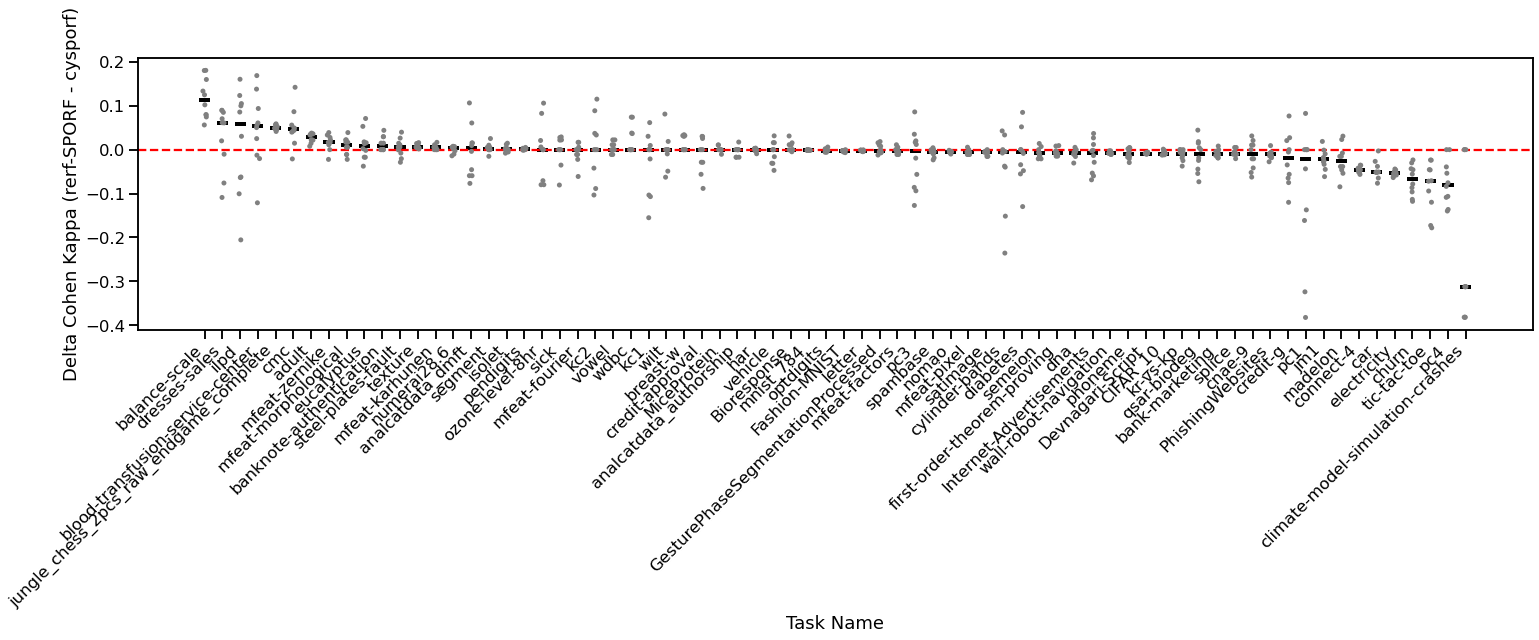

In [38]:
sns.set_context(
    "talk",
    #                 font_scale=1.25
)
fig, ax = plt.subplots(figsize=(25, 5))

sns.stripplot(
    x="task",
    y="delta_cohen_kappa",
    data=diff_df_melt,
    color="gray",
    order=order.index,
    ax=ax,
)

# distance across the "X" or "Y" stipplot column to span, in this case 40%
median_width = 0.4
df = diff_df_melt
for tick, text in zip(ax.get_xticks(), ax.get_xticklabels()):
    sample_name = text.get_text()  # "X" or "Y"

    # calculate the median value for all replicates of either X or Y
    median_val = df[df["task"] == sample_name]["delta_cohen_kappa"].median()

    # plot horizontal lines across the column, centered on the tick
    ax.plot(
        [tick - median_width / 2, tick + median_width / 2],
        [median_val, median_val],
        lw=4,
        color="k",
    )
ax.axhline([0], color="red", ls="--", label="No Change")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

ax.set(ylabel="Delta Cohen Kappa (rerf-SPORF - cysporf)", xlabel="Task Name")
# fig.tight_layout()
print("done")

done


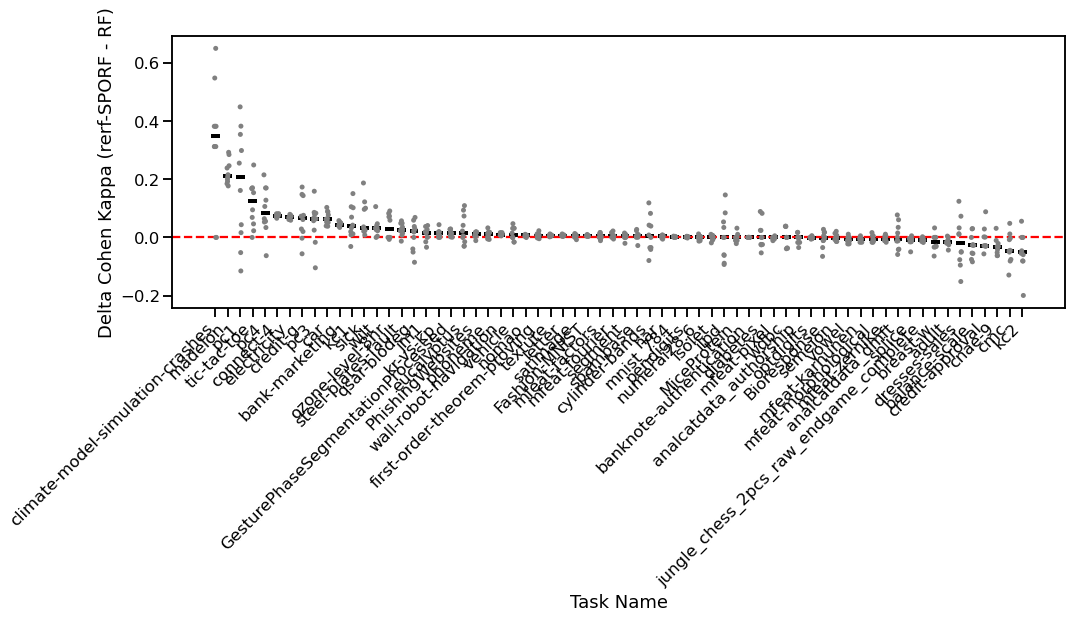

In [78]:
sns.set_context(
    "talk",
    #                 font_scale=1.25
)
fig, ax = plt.subplots(figsize=(25, 5))

sns.stripplot(
    x="task",
    y="delta_cohen_kappa",
    data=diff_df_melt,
    color="gray",
    order=order.index,
    ax=ax,
)

# distance across the "X" or "Y" stipplot column to span, in this case 40%
median_width = 0.4
df = diff_df_melt
for tick, text in zip(ax.get_xticks(), ax.get_xticklabels()):
    sample_name = text.get_text()  # "X" or "Y"

    # calculate the median value for all replicates of either X or Y
    median_val = df[df["task"] == sample_name]["delta_cohen_kappa"].median()

    # plot horizontal lines across the column, centered on the tick
    ax.plot(
        [tick - median_width / 2, tick + median_width / 2],
        [median_val, median_val],
        lw=4,
        color="k",
    )
ax.axhline([0], color="red", ls="--", label="No Change")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

ax.set(ylabel="Delta Cohen Kappa (rerf-SPORF - RF)", xlabel="Task Name")
# fig.tight_layout()
print("done")

done


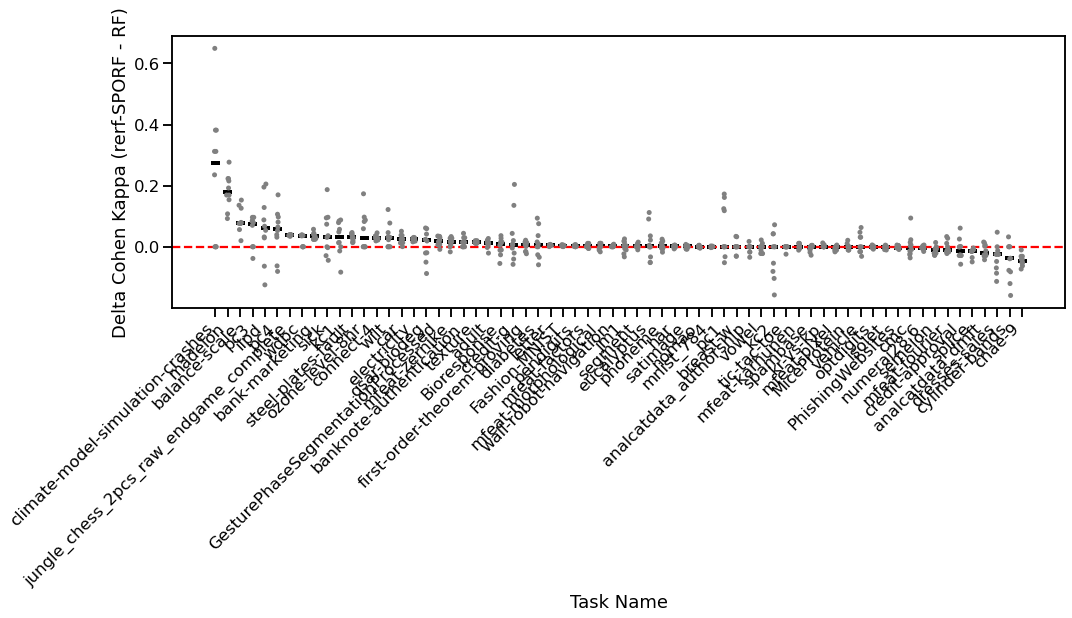

In [61]:
sns.set_context(
    "talk",
    #                 font_scale=1.25
)
fig, ax = plt.subplots(figsize=(16, 5))

sns.stripplot(
    x="task",
    y="delta_cohen_kappa",
    data=diff_df_melt,
    color="gray",
    order=order.index,
    ax=ax,
)

# distance across the "X" or "Y" stipplot column to span, in this case 40%
median_width = 0.4
df = diff_df_melt
for tick, text in zip(ax.get_xticks(), ax.get_xticklabels()):
    sample_name = text.get_text()  # "X" or "Y"

    # calculate the median value for all replicates of either X or Y
    median_val = df[df["task"] == sample_name]["delta_cohen_kappa"].median()

    # plot horizontal lines across the column, centered on the tick
    ax.plot(
        [tick - median_width / 2, tick + median_width / 2],
        [median_val, median_val],
        lw=4,
        color="k",
    )
ax.axhline([0], color="red", ls="--", label="No Change")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

ax.set(ylabel="Delta Cohen Kappa (rerf-SPORF - RF)", xlabel="Task Name")
# fig.tight_layout()
print("done")

done


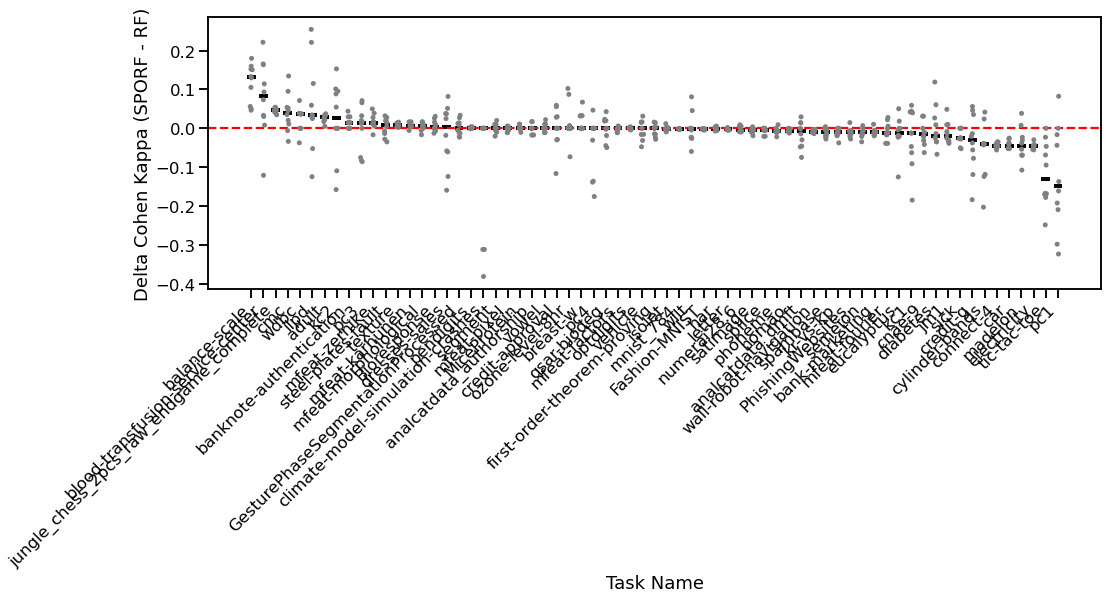

In [152]:
sns.set_context(
    "talk",
    #                 font_scale=1.25
)
fig, ax = plt.subplots(figsize=(16, 5))

sns.stripplot(
    x="task",
    y="delta_cohen_kappa",
    data=diff_df_melt,
    color="gray",
    order=order.index,
    ax=ax,
)

# distance across the "X" or "Y" stipplot column to span, in this case 40%
median_width = 0.4
df = diff_df_melt
for tick, text in zip(ax.get_xticks(), ax.get_xticklabels()):
    sample_name = text.get_text()  # "X" or "Y"

    # calculate the median value for all replicates of either X or Y
    median_val = df[df["task"] == sample_name]["delta_cohen_kappa"].median()

    # plot horizontal lines across the column, centered on the tick
    ax.plot(
        [tick - median_width / 2, tick + median_width / 2],
        [median_val, median_val],
        lw=4,
        color="k",
    )
ax.axhline([0], color="red", ls="--", label="No Change")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

ax.set(ylabel="Delta Cohen Kappa (SPORF - RF)", xlabel="Task Name")
# fig.tight_layout()
print("done")

# Pairplot

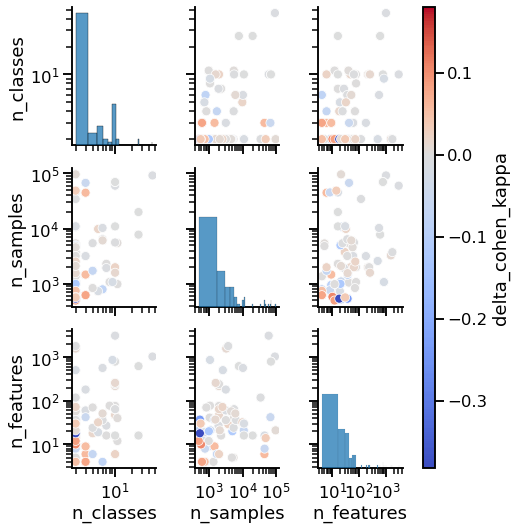

In [39]:
continuous_pairplot(
    diff_df_melt,
    vars=["n_classes", "n_samples", "n_features"],
    hue="delta_cohen_kappa",
    cmap="coolwarm",
)

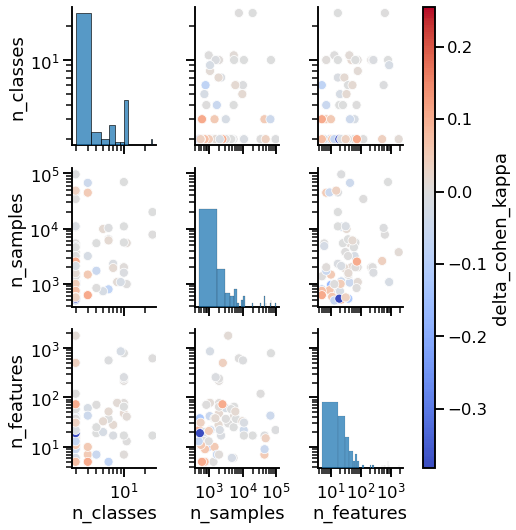

In [174]:
continuous_pairplot(
    diff_df_melt,
    vars=["n_classes", "n_samples", "n_features"],
    hue="delta_cohen_kappa",
    cmap="coolwarm",
)

# Analysis based on count

In [43]:
diff_df_melt["relative_rank"] = diff_df_melt["delta_cohen_kappa"]
diff_df_melt["relative_rank"] = diff_df_melt["relative_rank"].where(
    diff_df_melt["relative_rank"] < 0, other=1
)
diff_df_melt["relative_rank"] = diff_df_melt["relative_rank"].where(
    diff_df_melt["relative_rank"] == 1, other=0
)

display(diff_df_melt.head())

,task,n_samples,n_classes,task_id,n_features,cv_fold,delta_cohen_kappa,relative_rank
0,segment,2310,7,146822,16,0,-0.010101,0.0
1,jungle_chess_2pcs_raw_endgame_complete,44819,3,167119,6,0,0.039795,1.0
2,tic-tac-toe,958,2,49,9,0,0.000000,1.0
3,pc1,1109,2,3918,21,0,0.124572,1.0
4,analcatdata_dmft,797,6,3560,4,0,-0.026656,0.0


In [44]:
diff_df_melt.groupby("relative_rank").count()

,task,n_samples,n_classes,task_id,n_features,cv_fold,delta_cohen_kappa
relative_rank,,,,,,,
0.0,201,201,201,201,201,201,201
1.0,1119,1119,1119,1119,1119,1119,459


# Analysis based on number of classes

In [40]:
# compute descending order by median
order = (
    diff_df_melt.groupby("n_classes")
    .median()
    .sort_values(by="delta_cohen_kappa", ascending=False)
)

done


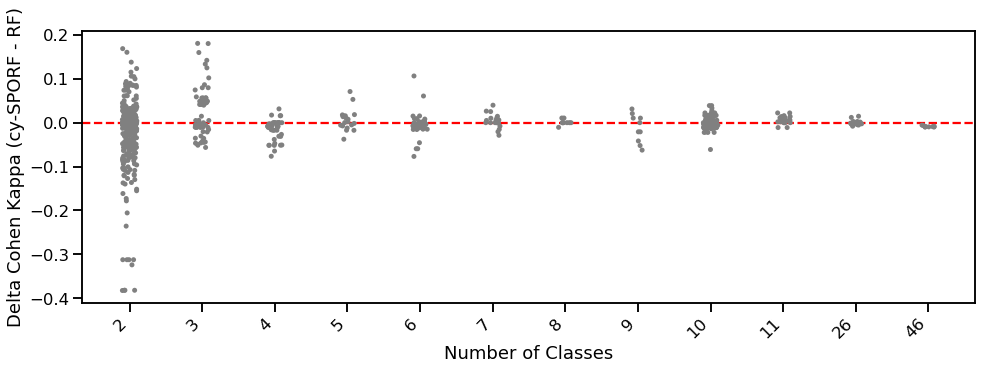

In [42]:
sns.set_context(
    "talk",
    #                 font_scale=1.25
)
fig, ax = plt.subplots(figsize=(16, 5))

sns.stripplot(
    x="n_classes",
    y="delta_cohen_kappa",
    data=diff_df_melt,
    color="gray",
    #     order=order.inde,x,
    ax=ax,
)

# distance across the "X" or "Y" stipplot column to span, in this case 40%
median_width = 0.4
df = diff_df_melt
for tick, text in zip(ax.get_xticks(), ax.get_xticklabels()):
    sample_name = text.get_text()  # "X" or "Y"

    # calculate the median value for all replicates of either X or Y
    median_val = df[df["n_classes"] == sample_name]["delta_cohen_kappa"].median()

    # plot horizontal lines across the column, centered on the tick
    ax.plot(
        [tick - median_width / 2, tick + median_width / 2],
        [median_val, median_val],
        lw=10,
        color="k",
    )
ax.axhline([0], color="red", ls="--", label="No Change")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

ax.set(ylabel="Delta Cohen Kappa (cy-SPORF - RF)", xlabel="Number of Classes")
# fig.tight_layout()
print("done")

done


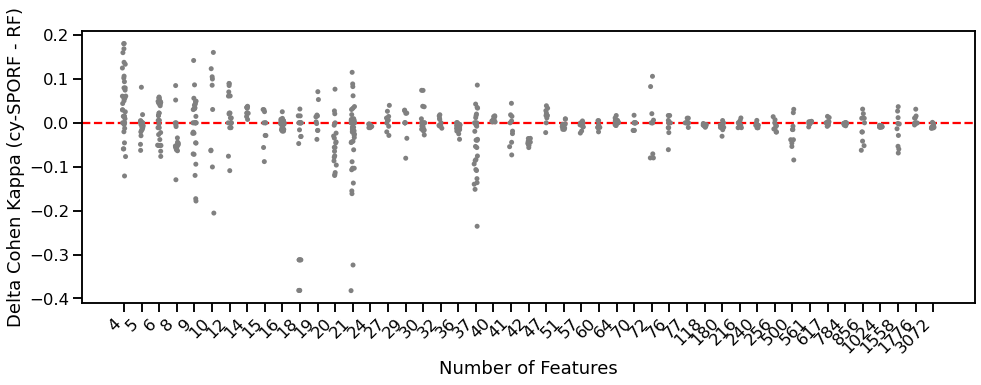

In [43]:
sns.set_context(
    "talk",
    #                 font_scale=1.25
)
fig, ax = plt.subplots(figsize=(16, 5))

sns.stripplot(
    x="n_features",
    y="delta_cohen_kappa",
    data=diff_df_melt,
    color="gray",
    #     order=order.inde,x,
    ax=ax,
)

# distance across the "X" or "Y" stipplot column to span, in this case 40%
median_width = 0.4
df = diff_df_melt
for tick, text in zip(ax.get_xticks(), ax.get_xticklabels()):
    sample_name = text.get_text()  # "X" or "Y"

    # calculate the median value for all replicates of either X or Y
    median_val = df[df["n_features"] == sample_name]["delta_cohen_kappa"].median()

    # plot horizontal lines across the column, centered on the tick
    ax.plot(
        [tick - median_width / 2, tick + median_width / 2],
        [median_val, median_val],
        lw=10,
        color="k",
    )
ax.axhline([0], color="red", ls="--", label="No Change")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

ax.set(ylabel="Delta Cohen Kappa (cy-SPORF - RF)", xlabel="Number of Features")
# fig.tight_layout()
print("done")

done


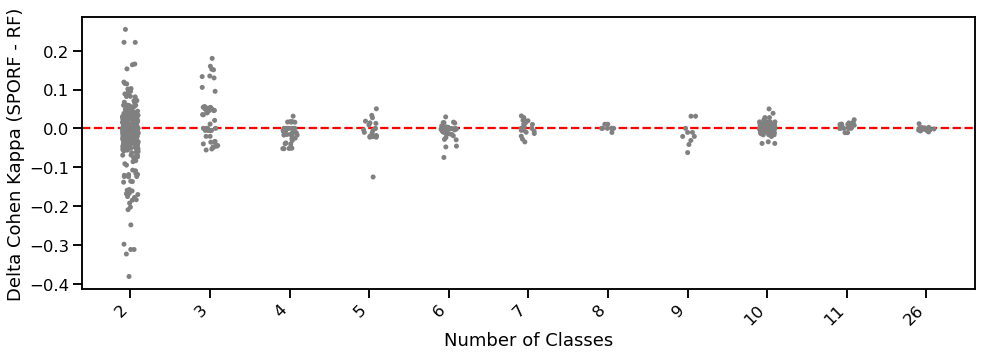

In [90]:
sns.set_context(
    "talk",
    #                 font_scale=1.25
)
fig, ax = plt.subplots(figsize=(16, 5))

sns.stripplot(
    x="n_classes",
    y="delta_cohen_kappa",
    data=diff_df_melt,
    color="gray",
    #     order=order.inde,x,
    ax=ax,
)

# distance across the "X" or "Y" stipplot column to span, in this case 40%
median_width = 0.4
df = diff_df_melt
for tick, text in zip(ax.get_xticks(), ax.get_xticklabels()):
    sample_name = text.get_text()  # "X" or "Y"

    # calculate the median value for all replicates of either X or Y
    median_val = df[df["n_classes"] == sample_name]["delta_cohen_kappa"].median()

    # plot horizontal lines across the column, centered on the tick
    ax.plot(
        [tick - median_width / 2, tick + median_width / 2],
        [median_val, median_val],
        lw=10,
        color="k",
    )
ax.axhline([0], color="red", ls="--", label="No Change")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

ax.set(ylabel="Delta Cohen Kappa (rerf-SPORF - RF)", xlabel="Number of Classes")
# fig.tight_layout()
print("done")

done


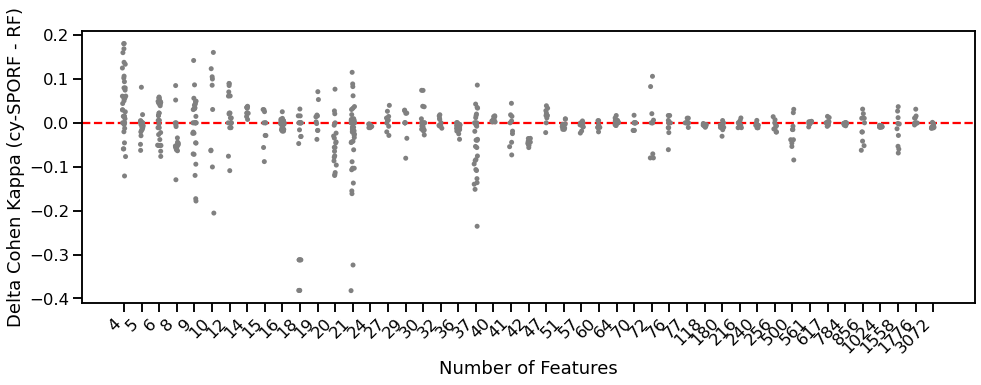

In [43]:
sns.set_context(
    "talk",
    #                 font_scale=1.25
)
fig, ax = plt.subplots(figsize=(16, 5))

sns.stripplot(
    x="n_features",
    y="delta_cohen_kappa",
    data=diff_df_melt,
    color="gray",
    #     order=order.inde,x,
    ax=ax,
)

# distance across the "X" or "Y" stipplot column to span, in this case 40%
median_width = 0.4
df = diff_df_melt
for tick, text in zip(ax.get_xticks(), ax.get_xticklabels()):
    sample_name = text.get_text()  # "X" or "Y"

    # calculate the median value for all replicates of either X or Y
    median_val = df[df["n_features"] == sample_name]["delta_cohen_kappa"].median()

    # plot horizontal lines across the column, centered on the tick
    ax.plot(
        [tick - median_width / 2, tick + median_width / 2],
        [median_val, median_val],
        lw=10,
        color="k",
    )
ax.axhline([0], color="red", ls="--", label="No Change")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

ax.set(ylabel="Delta Cohen Kappa (rerf-SPORF - RF)", xlabel="Number of Features")
# fig.tight_layout()
print("done")